# Package Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import math
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
#tqdm = partial(tqdm, position=0, leave=True)
from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
!pip install wandb
import wandb
!pip install plotly
import plotly
from scipy.io import loadmat
import pandas as pd
from torch import tanh
from torch.optim.lr_scheduler import StepLR
import plotly.graph_objects as go
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
drive.mount('/content/drive')
from rich import print

     |████████████████████████████████| 1.7 MB 4.3 MB/s 
     |████████████████████████████████| 140 kB 49.5 MB/s 
     |████████████████████████████████| 97 kB 6.0 MB/s 
     |████████████████████████████████| 180 kB 37.8 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=57215b21525aa55813e1c694592b830992e34aa1d4c8c71cd2cfabd4ccd132b6
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=275c1d6a4b70db82670d97a0907d41664a3a6ebdb0ab562517fe0265f1e3fd98
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
Mounted at /content/drive


ModuleNotFoundError: ignored

# With Wandb

Create sweep with ID: 82l71gkm
Sweep URL: https://wandb.ai/adamzen/Validation%20included%20in%20training%201000%20epoch/sweeps/82l71gkm


wandb: Agent Starting Run: afepsoar with config:
wandb: 	batch_size: 970
wandb: 	epochs: 92
wandb: 	epsilon: 0.003183098861837907
wandb: 	gridRes: 9700
wandb: 	lambda1: 1
wandb: 	lambda2: 1
wandb: 	lambda3: 1
wandb: 	lambda4: 1
wandb: 	learning_rate: 0.01
wandb: 	nodes_per_layer: 10
wandb: 	sample: 100
wandb: 	val_num: 1


BCloss,██▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ICloss,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,█▇▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
PDEloss,▁▁▅█▆▆▆▅▅▅▅▅▅▅▄▅▄▄▅▄▄▄▅▄▄▄▄▄▅▄▄▄▄▃▄▃▄▄▄▄
Validation_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
vallos,▆▄█▅▃▃▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
BCloss,0.00061
ICloss,0.00415
Loss,0.02016
PDEloss,0.0154


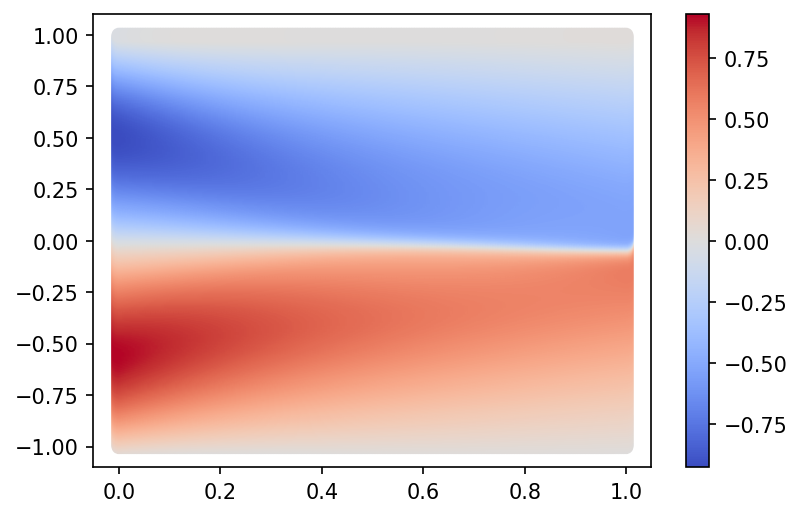

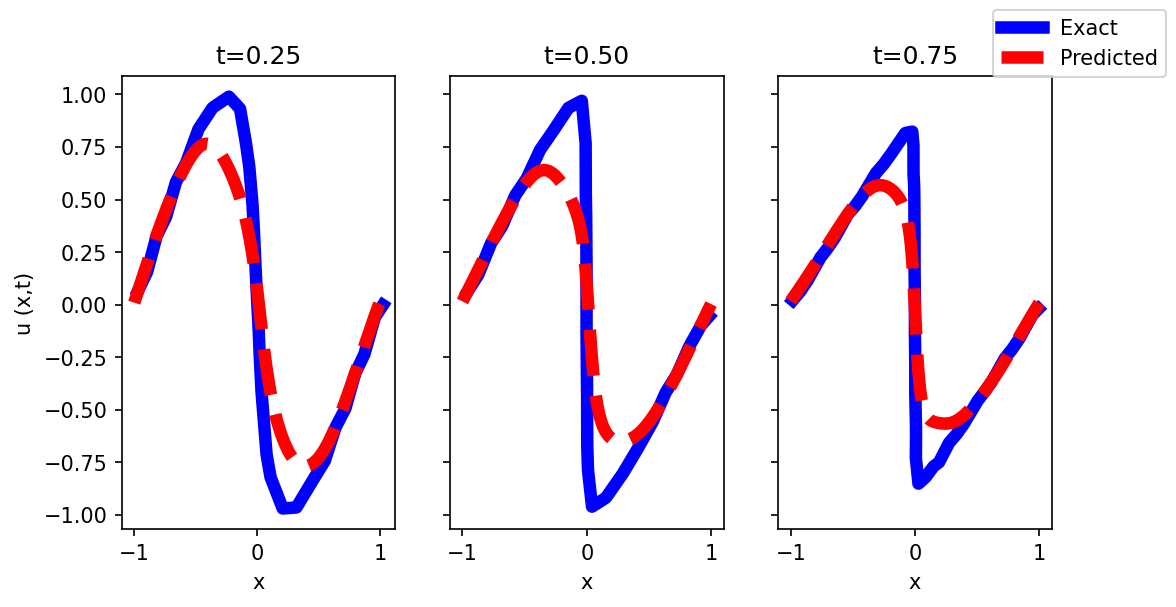

In [ ]:


#Hyperparameters
#----------------------------------------------------------------------------------------------------------------------------
# Here is where the hyper parameters are tuned, every run is a sweep in wandb because it was convenient at the time.
#
#
#
#
#----------------------------------------------------------------------------------------------------------------------------   
sweep_config = {
    "name" : "Burger Sweep",
    "method" : "bayes",
    "metric" : {
        "name" : "Validation_loss",
        "goal" : "minimize"
    },
    "parameters" : {
        "epochs": { "min" : 50,"max" : 500},
        "batch_size" : {"values" : [97,970,9700,485]},
        "gridRes" : {"value" : 9700},
        "nodes_per_layer" : {"value" : 10},
        "lambda1" : {"value" : 1},
        "lambda2" : {"value" : 1},
        "lambda3" : {"value" : 1},
        "lambda4" : {"value" : 1},
        #"BCsample" : {"min" : 10,"max" : 500},
        #"ICsample" : {"min" : 10,"max" : 500},
        "val_num" : {"value" : 1},
        "sample" : {"value" : 100},
        "epsilon" : {"value" : 0.01/math.pi},
        "learning_rate" : {"value" : 0.01},
        #"decrease" : {"min" : 1 ,"max" : 20}
    }
}
#Model
#----------------------------------------------------------------------------------------------------------------------------
#Here the FFNN is defined, not the one with modular layers but we could easily swap that out
#
#
#
#
#----------------------------------------------------------------------------------------------------------------------------   

class Net(nn.Module):
    def __init__(self,dim,L1):
        super(Net, self).__init__()
        self.drop = nn.Dropout(0.1)
        self.l_1 = nn.Linear(in_features=dim,
                            out_features=L1,
                            bias=True)
        self.l_2 = nn.Linear(in_features=L1,
                            out_features=L1,
                            bias=True)
        self.l_3 = nn.Linear(in_features=L1,
                            out_features=L1,
                            bias=True)
        self.l_4 = nn.Linear(in_features=L1,
                            out_features=L1,
                            bias=True)
        self.l_5 = nn.Linear(in_features=L1,
                             out_features=L1,
                             bias=True)
        self.l_out = nn.Linear(in_features=L1,
                            out_features=1,
                            bias=True) #IF EVERYTHING  BROKEN CHANGE THIS BACK TO FALSE
        for param in self.parameters():
          if len(param.shape) > 1:
            nn.init.xavier_normal_(param)

        
    def forward(self,x):
       
        x = tanh(self.l_1(x))
        #x = self.drop(x)
        x = tanh(self.l_2(x))
        #x = self.drop(x)
        x = tanh(self.l_3(x))
        #x = self.drop(x)
        x = tanh(self.l_4(x))
        #x = self.drop(x)
        x = tanh(self.l_5(x))
        #x = self.drop(x)
        x = (self.l_out(x))
        
        return x

#Training Loop
#----------------------------------------------------------------------------------------------------------------------------
# The training loop is defined in a function so it can be called by wandb
#
#
#
#
#----------------------------------------------------------------------------------------------------------------------------   
def train(config=sweep_config):


  with wandb.init(config=config):
    #Data Loading
    data = loadmat('/content/drive/My Drive/Project - Deep Learning - PINN/burgers_shock.mat')
    x = data['x'].squeeze()
    t = data['t'].squeeze()
    u_val = data['usol']
    X,T=np.meshgrid(x,t)
    positions = np.vstack([T.ravel(), X.ravel()])


    

    #Extracting hyperparameters from the dictionary defined above
    config=wandb.config
    epsilon=config.epsilon #Viscosity term
    epochs = config.epochs # Number of epoch
    batch_size = config.batch_size # full batches 

    nodes_per_layer = config.nodes_per_layer # units per layer

    lambda1 = config.lambda1 # Weight for the PDE loss
    lambda2 = config.lambda2 # Weight for the BC loss
    lambda3 = config.lambda3 # Weight for the IC loss
    lambda4 = config.lambda4 # Weight for the exact sol

    gridRes = config.gridRes # Number of datapoints within the bounds
    BCSample = config.sample # Number of BC samples
    ICSample = config.sample # Number of IC samples
    val_num = config.val_num # Number of validations
    
    learning_rate = config.learning_rate # Learning rate for Adam


    #Here the data is defined, generated uniformly randomly in the range we are in.
    n=gridRes
    datapoints=n
    input = np.random.uniform(low=[0,-1],high=[1,1],size=(n,2))
    input = torch.Tensor(input)
    input.requires_grad=True

    #Initial boundary: ic is x = -1 .. 1, zeros = array of just 0
    ic = np.linspace(-1,1,ICSample) 
    zeros=ic*0

    # Boundary: bc is t = 0..1 , ones array of just 1 and mones is array of -1
    bc = np.linspace(0,1,BCSample)
    zeros_bc=bc*0
    ones = zeros_bc+1 #Set the zero array to a array of just 1
    mones = zeros_bc-1#Set the zero array to a array of just -1
    

    #Converted to tensor
    data = TensorDataset(input) #To wrap the tensor data, Each sample will be retrieved by indexing tensors along the first dimension.
    loader=DataLoader(data,batch_size = batch_size,shuffle=True,drop_last=True) # Shuffle all data and seperate into batches

    #Initializing model
    burgerNet=Net(2,nodes_per_layer)

    # Define optimizers
    optimizer = optim.Adam(burgerNet.parameters(),lr=learning_rate)
    steplr = StepLR(optimizer, 
                step_size=2000, 
                gamma=0.7) # After 2000 epochs the learning rate of the optimizer is multiplied by gamma. So the value for the learning rate is declining across training!

    #Training Loop
    for epoch in tqdm(range(epochs),leave=False, position=0):  #Burgers equation in the box t=[0,1], x=[-1,1]

      for batch in loader:
        
        optimizer.zero_grad() #Reset the gradients
        batch = batch[0] #this is necessary for dataloader


        u = burgerNet(batch) # Forward

        
        # Calculate the derivatives of the differential equation
        grads = torch.autograd.grad(u,batch,torch.ones_like(u),create_graph=True)[0]
        u_t = grads[:,0] #Extract the partial derivative in respect to t
        u_x = grads[:,1] #Extract the partial derivative in respect to x
        uu_x = u[:,0]*u_x #Calculate other part for the differential eq.

        #Calculate the double derivative with respect to x_
        #u_xx = torch.autograd.grad(u_x,batch,torch.ones_like(u_x),create_graph=True,allow_unused=True)[0][:,1]
        u_xx = torch.autograd.grad(grads,batch,torch.ones_like(grads),create_graph=True)[0][:,1]

        #print(train_positions.shape,u_train.shape)

        # Construct the loss terms:
        step = int(25600/val_num)
        #Validation loss, exact solution - models solution
        Val_loss = torch.sum((burgerNet(torch.Tensor(positions[:,0::step].T))[:,0]-torch.Tensor(u_val.T.ravel()[0::step]))**2)/len(u_val.ravel())
        
        # Differential equation solution PDE
        PDEloss = torch.sum((u_t+uu_x-epsilon*u_xx)**2)/datapoints #Burger Equation loss  

        # Initial condition loss
        ICloss = ((burgerNet((torch.Tensor(np.transpose([zeros,ic]))))[:,0]-(-(torch.sin(torch.Tensor([math.pi*ic]))[0])))**2)
        ICloss = torch.sum(ICloss)/ICSample

        # Boundary condition loss
        BCloss = burgerNet((torch.Tensor(np.transpose([bc,mones]))))**2 + burgerNet((torch.Tensor(np.transpose([bc,ones]))))**2
        BCloss = torch.sum(BCloss)/(BCSample*2)

        # Weighted sum of all the losses
        Loss = lambda1*PDEloss+lambda2*BCloss+lambda3*ICloss+Val_loss*lambda4

        # Data logging in WandB
        wandb.log({"PDEloss" : PDEloss})
        wandb.log({"ICloss" : ICloss})
        wandb.log({"BCloss" : BCloss})
        wandb.log({"Loss" : Loss, "epoch" : epoch})
        wandb.log({"vallos" : Val_loss})


        # Backward pass:
        Loss.backward()
        optimizer.step()
        steplr.step()
        

    # Run trained model and visualize it:
    model=burgerNet
    gridRes=200
    input = np.meshgrid(np.arange(gridRes+1)/gridRes,np.arange(-gridRes,gridRes+1)/(gridRes))

    datapoints=(gridRes*2+1)*(gridRes+1)
    input = np.reshape(input,(2,datapoints))
    input = np.transpose(input)
    input = torch.Tensor(input)
    x = np.transpose(input.detach().numpy()) #For the plot

    output = burgerNet(input).detach().numpy() #forward åass

    fig1 = plt.figure(dpi=150)
    ax= plt.scatter(x[0],x[1],c=output,cmap="coolwarm")
    fig1.colorbar(ax)
    wandb.log({"colorbar" : wandb.Image(fig1)})
    
    # Load exact solution to visualize the results
    data = loadmat('/content/drive/My Drive/Project - Deep Learning - PINN/burgers_shock.mat')
    x = data['x'].squeeze()
    t = data['t'].squeeze()
    u = data['usol']
    actual_outputs_1 = pd.read_excel (r'/content/drive/My Drive/Project - Deep Learning - PINN/actual outputs/t=0.25.xlsx')
    actual_outputs_2 = pd.read_excel (r'/content/drive/My Drive/Project - Deep Learning - PINN/actual outputs/t=0.50.xlsx')
    actual_outputs_3 = pd.read_excel (r'/content/drive/My Drive/Project - Deep Learning - PINN/actual outputs/t=0.75.xlsx')
    

    x_t_25=np.hstack(( X[0:1,:].T, T[25:26,:].T)) # Data at t = 0.25
    x_t_50=np.hstack(( X[0:1,:].T, T[50:51,:].T))# Data at t = 0.5
    x_t_75=np.hstack(( X[0:1,:].T, T[75:76,:].T))# Data at t = 0.75
    x_t_25[:, [0,1]] = x_t_25[:, [1,0]]
    x_t_50[:, [0,1]] = x_t_50[:, [1,0]]
    x_t_75[:, [0,1]] = x_t_75[:, [1,0]]
    fig, axs = plt.subplots(1, 3, figsize=(8,4) ,sharey=True,dpi=150)
    l1,=axs[0].plot(actual_outputs_1['x'], actual_outputs_1['t'],linewidth=6,color='b')
    l2,=axs[0].plot(x_t_25[:,1],model(torch.Tensor(x_t_25)).detach().numpy(),linewidth=6,linestyle='dashed',color='r')
    axs[0].set_title('t=0.25')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('u (x,t)')


    axs[1].plot(actual_outputs_2['x'],actual_outputs_2['t'],linewidth=6,color='b')
    axs[1].plot(x_t_50[:,1],model(torch.Tensor(x_t_50)).detach().numpy(),linewidth=6,linestyle='dashed',color='r')
    axs[1].set_title('t=0.50')
    axs[1].set_xlabel('x')

    axs[2].plot(actual_outputs_3['x'], actual_outputs_3['t'],linewidth=6,color='b')
    axs[2].plot(x_t_75[:,1],model(torch.Tensor(x_t_75)).detach().numpy(),linewidth=6,linestyle='dashed',color='r')
    axs[2].set_title('t=0.75')
    axs[2].set_xlabel('x')

    #line_labels = ['Exact','Predicted']

    fig.legend(handles=(l1,l2),labels=('Exact','Predicted'),loc='upper right')
    wandb.log({"sins: " : wandb.Image(fig)})
    fig.show()

    Validation_loss = torch.sum((burgerNet(torch.Tensor(positions.T))[:,0]-torch.Tensor(u.T.ravel()))**2)/len(u.ravel())
    
    wandb.log({"Validation_loss" : Validation_loss})
    
#----------------------------------------------------------------------------------------------------------------------------
#
#
#
#
#
#----------------------------------------------------------------------------------------------------------------------------   
      

sweep_id = wandb.sweep(sweep_config,project = "Validation included in training 1000 epoch")

wandb.agent(sweep_id, train,count = 1)

# Without wandb


{'Validation_loss': tensor(0.0542, grad_fn=<DivBackward0>)}


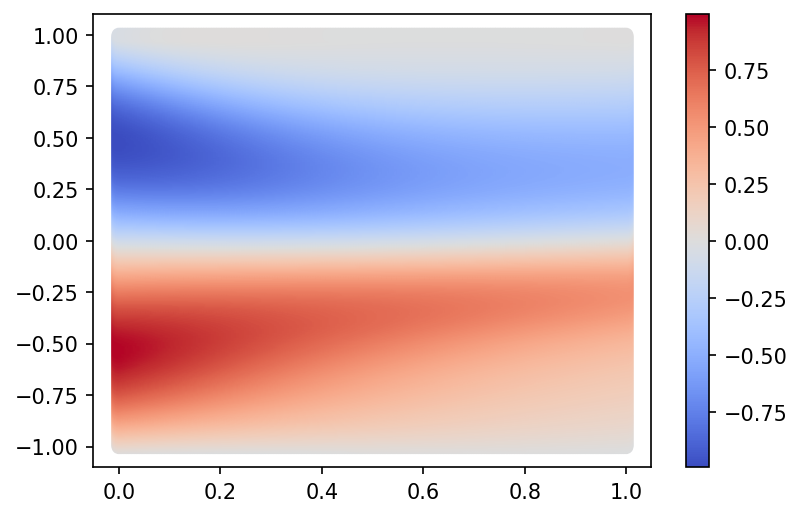

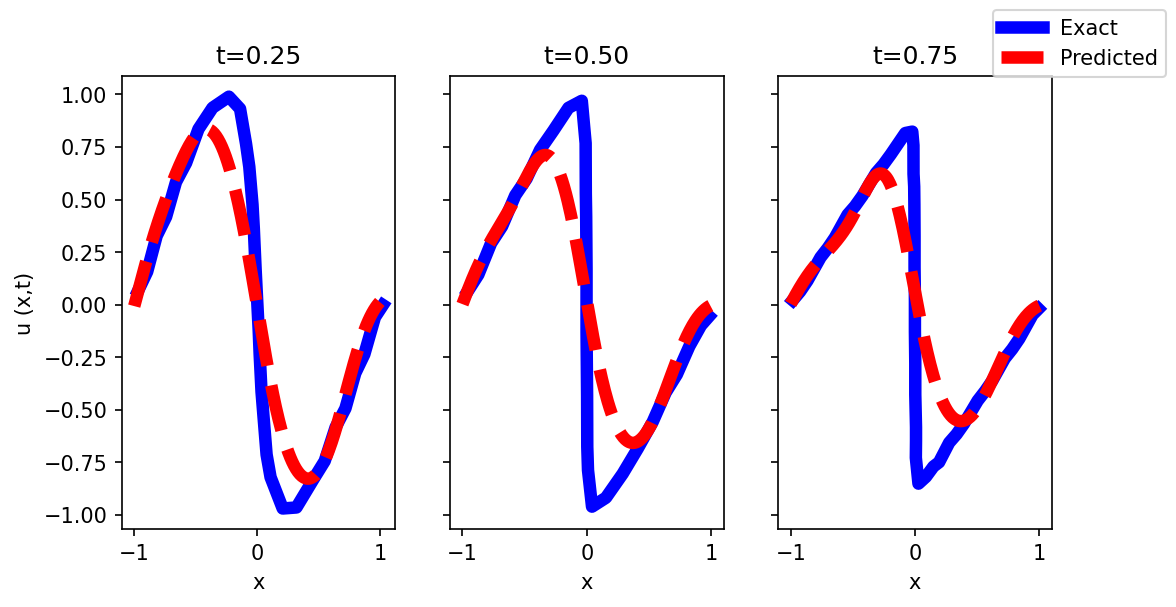

In [ ]:
#Hyperparameters
#----------------------------------------------------------------------------------------------------------------------------
# Here is where the hyper parameters are tuned, every run is a sweep in wandb because it was convenient at the time.
#
#
#
#
#----------------------------------------------------------------------------------------------------------------------------   
sweep_config = {

        "epochs": 200,
        "batch_size" : 16,
        "gridRes" : 9700,
        "nodes_per_layer" : 10,
        "lambda1" : 4.878,
        "lambda2" : 4.049,
        "lambda3" : 2.582,
        "lambda4" : 1,
        "val_num" : 1,
        "sample" : 100,
        "epsilon" :  0.01/math.pi,
        "learning_rate" :  0.01
        
}
#Model
#----------------------------------------------------------------------------------------------------------------------------
#Here the FFNN is defined, not the one with modular layers but we could easily swap that out
#
#
#
#
#----------------------------------------------------------------------------------------------------------------------------   

class Net(nn.Module):
    def __init__(self,dim,L1):
        super(Net, self).__init__()
        self.drop = nn.Dropout(0.1)
        self.l_1 = nn.Linear(in_features=dim,
                            out_features=L1,
                            bias=True)
        self.l_2 = nn.Linear(in_features=L1,
                            out_features=L1,
                            bias=True)
        self.l_3 = nn.Linear(in_features=L1,
                            out_features=L1,
                            bias=True)
        self.l_4 = nn.Linear(in_features=L1,
                            out_features=L1,
                            bias=True)
        self.l_5 = nn.Linear(in_features=L1,
                             out_features=L1,
                             bias=True)
        self.l_out = nn.Linear(in_features=L1,
                            out_features=1,
                            bias=True) #IF EVERYTHING  BROKEN CHANGE THIS BACK TO FALSE
        for param in self.parameters():
          if len(param.shape) > 1:
            nn.init.xavier_normal_(param)

        
    def forward(self,x):
       
        x = tanh(self.l_1(x))
        x = tanh(self.l_2(x))
        x = tanh(self.l_3(x))
        x = tanh(self.l_4(x))
        x = tanh(self.l_5(x))
        x = (self.l_out(x))
        
        return x

#Training Loop
#----------------------------------------------------------------------------------------------------------------------------
# The training loop is defined in a function so it can be called by wandb
#
#
#
#
#----------------------------------------------------------------------------------------------------------------------------   
def train(config=sweep_config):



  #Data Loading
  data = loadmat('/content/drive/My Drive/Project - Deep Learning - PINN/burgers_shock.mat')
  x = data['x'].squeeze()
  t = data['t'].squeeze()
  u_val = data['usol']
  X,T=np.meshgrid(x,t)
  positions = np.vstack([T.ravel(), X.ravel()])


  

  #Extracting hyperparameters from the dictionary defined above
  
  epsilon=config["epsilon"] #Viscosity term
  epochs = config["epochs"] # Number of epoch
  batch_size = config["batch_size"] # full batches 

  nodes_per_layer = config["nodes_per_layer"] # units per layer

  lambda1 = config["lambda1"] # Weight for the PDE loss
  lambda2 = config["lambda2"] # Weight for the BC loss
  lambda3 = config["lambda3"] # Weight for the IC loss
  lambda4 = config["lambda4"] # Weight for the exact sol

  gridRes = config["gridRes"] # Number of datapoints within the bounds
  BCSample = config["sample"] # Number of BC samples
  ICSample = config["sample"] # Number of IC samples
  val_num = config["val_num"] # Number of validations
  
  learning_rate = config["learning_rate"] # Learning rate for Adam


  #Here the data is defined, generated uniformly randomly in the range we are in.
  n=gridRes
  datapoints=n
  input = np.random.uniform(low=[0,-1],high=[1,1],size=(n,2))
  input = torch.Tensor(input)#.cuda()
  input.requires_grad=True

  #Initial boundary: ic is x = -1 .. 1, zeros = array of just 0
  ic = np.linspace(-1,1,ICSample) 
  zeros=ic*0

  # Boundary: bc is t = 0..1 , ones array of just 1 and mones is array of -1
  bc = np.linspace(0,1,BCSample)
  zeros_bc=bc*0
  ones = zeros_bc+1 #Set the zero array to a array of just 1
  mones = zeros_bc-1#Set the zero array to a array of just -1
  

  #Converted to tensor
  data = TensorDataset(input) #To wrap the tensor data, Each sample will be retrieved by indexing tensors along the first dimension.
  loader=DataLoader(data,batch_size = batch_size,shuffle=True,drop_last=True) # Shuffle all data and seperate into batches

  #Initializing model
  burgerNet=Net(2,nodes_per_layer)#.cuda()

  # Define optimizers
  optimizer = optim.Adam(burgerNet.parameters(),lr=learning_rate)
  optimizer2 = optim.LBFGS(burgerNet.parameters())
  steplr = StepLR(optimizer, 
              step_size=100, 
              gamma=0.7) # After 2000 epochs the learning rate of the optimizer is multiplied by gamma. So the value for the learning rate is declining across training!

  #Training Loop
  for epoch in tqdm(range(epochs),leave=False, position=0):  #Burgers equation in the box t=[0,1], x=[-1,1]

    for batch in loader:
      
      optimizer.zero_grad() #Reset the gradients
      batch = batch[0] #this is necessary for dataloader


      u = burgerNet(batch) # Forward

      
      # Calculate the derivatives of the differential equation
      grads = torch.autograd.grad(u,batch,torch.ones_like(u),create_graph=True)[0]#addcuda
      u_t = grads[:,0] #Extract the partial derivative in respect to t
      u_x = grads[:,1] #Extract the partial derivative in respect to x
      uu_x = u[:,0]*u_x #Calculate other part for the differential eq.
      
      #print(u.shape,u_x.shape,uu_x.shape)

      #Calculate the double derivative with respect to x_
      #u_xx = torch.autograd.grad(u_x,batch,torch.ones_like(u_x),create_graph=True,allow_unused=True)[0][:,1]
      u_xx = torch.autograd.grad(grads,batch,torch.ones_like(grads),create_graph=True)[0][:,1]#addcuda

      #print(train_positions.shape,u_train.shape)

      # Construct the loss terms:
      step = int(25600/val_num)
      #Validation loss, exact solution - models solution
      Val_loss = torch.sum((burgerNet(torch.Tensor(positions[:,0::step].T))[:,0]-torch.Tensor(u_val.T.ravel()[0::step]))**2)/len(u_val.ravel()) #cudas
      
      # Differential equation solution PDE
      PDEloss = torch.sum((u_t+uu_x-epsilon*u_xx)**2)/datapoints #Burger Equation loss  

      # Initial condition loss
      ICloss = ((burgerNet((torch.Tensor(np.transpose([zeros,ic]))))[:,0]-(-(torch.sin(torch.Tensor([math.pi*ic]))[0])))**2)#cudas
      ICloss = torch.sum(ICloss)/ICSample

      # Boundary condition loss
      BCloss = burgerNet((torch.Tensor(np.transpose([bc,mones]))))**2 + burgerNet((torch.Tensor(np.transpose([bc,ones]))))**2#cudas
      BCloss = torch.sum(BCloss)/(BCSample*2)

      # Weighted sum of all the losses
      Loss = lambda1*PDEloss+lambda2*BCloss+lambda3*ICloss#+Val_loss*lambda4

      if epoch%500==0 and epoch!=0:
        print({"PDEloss" : PDEloss})
        print({"ICloss" : ICloss})
        print({"BCloss" : BCloss})
        print({"Loss" : Loss, "epoch" : epoch})
        print({"vallos" : Val_loss})
        #print(uu_x.shape)
        #print(u_x.shape)
        #print(u_t.shape)
        #print(u_xx.shape)

      # Backward pass:
      Loss.backward()
      optimizer.step()
      steplr.step()
   

  """
  # FINETUNING Training loop
  for epoch in tqdm(range(int(epochs/10)),leave=False, position=0):  #Burgers equation in the box t=[0,1], x=[-1,1]

    for batch in loader:
      def closure(batch=batch):
        optimizer2.zero_grad() #Reset the gradients
        batch = batch[0] #this is necessary for dataloader


        u = burgerNet(batch) # Forward

        
        # Calculate the derivatives of the differential equation
        grads = torch.autograd.grad(u,batch,torch.ones_like(u),create_graph=True)[0]#addcuda
        u_t = grads[:,0] #Extract the partial derivative in respect to t
        u_x = grads[:,1] #Extract the partial derivative in respect to x
        uu_x = u[:,0]*u_x #Calculate other part for the differential eq.
        
        #print(u.shape,u_x.shape,uu_x.shape)

        #Calculate the double derivative with respect to x_
        #u_xx = torch.autograd.grad(u_x,batch,torch.ones_like(u_x),create_graph=True,allow_unused=True)[0][:,1]
        u_xx = torch.autograd.grad(grads,batch,torch.ones_like(grads),create_graph=True)[0][:,1]#addcuda

        #print(train_positions.shape,u_train.shape)

        # Construct the loss terms:
        step = int(25600/val_num)
        #Validation loss, exact solution - models solution
        #Val_loss = torch.sum((burgerNet(torch.Tensor(positions[:,0::step].T))[:,0]-torch.Tensor(u_val.T.ravel()[0::step]))**2)/len(u_val.ravel()) #cudas
        
        # Differential equation solution PDE
        PDEloss = torch.sum((u_t+uu_x-epsilon*u_xx)**2)/datapoints #Burger Equation loss  

        # Initial condition loss
        ICloss = ((burgerNet((torch.Tensor(np.transpose([zeros,ic]))))[:,0]-(-(torch.sin(torch.Tensor([math.pi*ic]))[0])))**2)#cudas
        ICloss = torch.sum(ICloss)/ICSample

        # Boundary condition loss
        BCloss = burgerNet((torch.Tensor(np.transpose([bc,mones]))))**2 + burgerNet((torch.Tensor(np.transpose([bc,ones]))))**2#cudas
        BCloss = torch.sum(BCloss)/(BCSample*2)

        # Weighted sum of all the losses
        Loss = lambda1*PDEloss+lambda2*BCloss+lambda3*ICloss#+Val_loss*lambda4


        # Backward pass:
        Loss.backward(retain_graph=True)
        return Loss
      optimizer2.step(closure)

  """ 
   
  # Run trained model and visualize it:
  model=burgerNet
  gridRes=200
  input = np.meshgrid(np.arange(gridRes+1)/gridRes,np.arange(-gridRes,gridRes+1)/(gridRes))

  datapoints=(gridRes*2+1)*(gridRes+1)
  input = np.reshape(input,(2,datapoints))
  input = np.transpose(input)
  input = torch.Tensor(input)
  x = np.transpose(input.cpu().detach().numpy()) #For the plot

  output = burgerNet(input).cpu().detach().numpy() #forward åass

  fig1 = plt.figure(dpi=150)
  ax= plt.scatter(x[0],x[1],c=output,cmap="coolwarm")
  fig1.colorbar(ax)
  fig1.show()

  
  # Load exact solution to visualize the results
  data = loadmat('/content/drive/My Drive/Project - Deep Learning - PINN/burgers_shock.mat')
  x = data['x'].squeeze()
  t = data['t'].squeeze()
  u = data['usol']
  actual_outputs_1 = pd.read_excel (r'/content/drive/My Drive/Project - Deep Learning - PINN/actual outputs/t=0.25.xlsx')
  actual_outputs_2 = pd.read_excel (r'/content/drive/My Drive/Project - Deep Learning - PINN/actual outputs/t=0.50.xlsx')
  actual_outputs_3 = pd.read_excel (r'/content/drive/My Drive/Project - Deep Learning - PINN/actual outputs/t=0.75.xlsx')
  

  x_t_25=np.hstack(( X[0:1,:].T, T[25:26,:].T)) # Data at t = 0.25
  x_t_50=np.hstack(( X[0:1,:].T, T[50:51,:].T))# Data at t = 0.5
  x_t_75=np.hstack(( X[0:1,:].T, T[75:76,:].T))# Data at t = 0.75
  x_t_25[:, [0,1]] = x_t_25[:, [1,0]]
  x_t_50[:, [0,1]] = x_t_50[:, [1,0]]
  x_t_75[:, [0,1]] = x_t_75[:, [1,0]]
  fig, axs = plt.subplots(1, 3, figsize=(8,4) ,sharey=True,dpi=150)
  l1,=axs[0].plot(actual_outputs_1['x'], actual_outputs_1['t'],linewidth=6,color='b')
  l2,=axs[0].plot(x_t_25[:,1],model(torch.Tensor(x_t_25)).detach().numpy(),linewidth=6,linestyle='dashed',color='r')
  axs[0].set_title('t=0.25')
  axs[0].set_xlabel('x')
  axs[0].set_ylabel('u (x,t)')


  axs[1].plot(actual_outputs_2['x'],actual_outputs_2['t'],linewidth=6,color='b')
  axs[1].plot(x_t_50[:,1],model(torch.Tensor(x_t_50)).detach().numpy(),linewidth=6,linestyle='dashed',color='r')
  axs[1].set_title('t=0.50')
  axs[1].set_xlabel('x')

  axs[2].plot(actual_outputs_3['x'], actual_outputs_3['t'],linewidth=6,color='b')
  axs[2].plot(x_t_75[:,1],model(torch.Tensor(x_t_75)).detach().numpy(),linewidth=6,linestyle='dashed',color='r')
  axs[2].set_title('t=0.75')
  axs[2].set_xlabel('x')

  #line_labels = ['Exact','Predicted']

  fig.legend(handles=(l1,l2),labels=('Exact','Predicted'),loc='upper right')
  
  fig.show()

  Validation_loss = torch.sum((burgerNet(torch.Tensor(positions.T))[:,0]-torch.Tensor(u.T.ravel()))**2)/len(u.ravel())
  
  print({"Validation_loss" : Validation_loss})
    
#----------------------------------------------------------------------------------------------------------------------------
#
#
#
#
#
#----------------------------------------------------------------------------------------------------------------------------   
      

train(sweep_config)